In [1]:
import json
import argparse
from tqdm import tqdm
import pickle
import matplotlib.pyplot as plt
import numpy as np
from itertools import chain
import seaborn as sns
palette = sns.color_palette("colorblind")
! pip install tabulate
from tabulate import tabulate
import pandas as pd

In [8]:
def read_data(task, mode, mem, idx, folder="raw_data/",suffix=None):  
    if suffix is not None:
        file_name=f"{folder}{task}_{mode}_{mem}_{idx}_{suffix}.json"  
    else:
        file_name=f"{folder}{task}_{mode}_{mem}_{idx}.json"
    with open(file_name, "r") as f:
        data = json.load(f)
       
    return data

In [9]:
def get_iter_time(data, start):
    return np.array(data["iter_time"][start:])

In [10]:
def get_forward_time(data, start):
    return np.array(data["forward_per_iter"][start:])

def get_attn_mem_per_iter(data, start):
    return np.array(data["attn_mem_per_iter"][start:])

def get_attn_comp_per_iter(data, start):
    return np.array(data["attn_comp_per_iter"][start:])

In [11]:
def get_prepare_time(data, start):
    return np.array(data["prepare_per_iter"][start:])

In [12]:
task="speculative_decoding"
methods=["radix","deft_flatten", "deft_node","deft_node_chunk"] 


In [13]:
#  the load function to get the data of each keys in a json file.
# Note that those two keys needs to get the sum of the values in the list as well: attn_comp_e2e = np.array(result["attn_comp_per_iter"][start:]).sum(), attn_mem_e2e = np.array(result["attn_mem_per_iter"][start:]).sum()
# return type: a dictnary to be used in the following plot and table drawing functions
def load(task, idx, folder="raw_data/",suffix=None):    
    start = 10
    deft_flatten = read_data(task, "flatten", "paged", idx, folder=folder,suffix=suffix)
    deft_node = read_data(task, "node", "paged", idx, folder=folder,suffix=suffix)
    deft_node_chunk = read_data(task, "node_chunk", "paged", idx, folder=folder,suffix=suffix)
    radix = read_data(task, "seq", "paged", idx, folder=folder,suffix=suffix)
    
    results = {
        "deft_flatten": deft_flatten,
        "deft_node": deft_node,
        "deft_node_chunk": deft_node_chunk,
        "radix": radix,
    }
    
    metrics = {}
    for key, result in results.items():
        forward_e2e = np.array(result["forward_per_iter"][start:]).sum()
        attn_comp_e2e = np.array(result["attn_comp_per_iter"][start:]).sum()
        attn_mem_e2e = np.array(result["attn_mem_per_iter"][start:]).sum()
        tpot = result["TPOT"]
        KV_IO = result["KV_IO"]
        Other_IO = result["QK_scale_IO"] + result["QK_scale_masked_IO"] + result["Mask_IO"] + result["SoftMax_IO"]
        
        metrics[key] = {
            "forward_e2e": forward_e2e,
            "attn_comp_e2e": attn_comp_e2e,
            "attn_mem_e2e": attn_mem_e2e,
            "tpot": tpot,
            "KV_IO": KV_IO,
            "Other_IO": Other_IO
        }
        
        # Print the results
        # print(
        #     f"|{idx:^16}|{key:^20}|{forward_e2e / 1000:^20.2f}|"
        #     f"{attn_comp_e2e / 1000:^20.2f}|{attn_mem_e2e / 1000:^20.2f}|"
        #     f"{attn_comp_e2e / 1000:^20.2f}|{KV_IO / 1e12:^20.2f}|{Other_IO / 1e12:^20.2f}|"
        # )
    
    return metrics



# reproduce experiment results in the deft paper
The prompt=~1k tokens, max_seq_len=6k tokens.
The logs are in "raw_data/meta-llama_Meta-Llama-3-8B/ref_data/".

In [ ]:
# Initialize storage structure
widths = [32, 64, 128, 256]
results_by_width = {}

# print(f"|{'width':^16}|{'op':^20}|{'Decoding (s)':^20}|{'attn_comp (s)':^20}|{'attn_mem (s)':^20}|{'attn (s)':^20}|{'KV_IO (TB)':^20}|{'Other_IO (TB)':^20}|\n"
#       f"|{'-' * 16}|{'-' * 20}|{'-' * 20}|{'-' * 20}|{'-' * 20}|{'-' * 20}|{'-' * 20}|{'-' * 20}|")

# Collect data into the corresponding width structure
for width in widths:
    metrics = load("speculative_decoding", width, folder="raw_data/meta-llama_Meta-Llama-3-8B/ref_data/")
    
    # Store into results_by_width
    results_by_width[width] = {
        "forward_e2e_avg": {method: metrics[method]["forward_e2e"] for method in metrics}, # decoding time
        "attn_e2e_avg": {method: metrics[method]["attn_comp_e2e"] for method in metrics}, # attn_comp time + memory management time
        "attn_mem_e2e_avg": {method: metrics[method]["attn_mem_e2e"] for method in metrics}, # attn_mem time(kv management)
        "attn_comp_e2e_avg": {method: metrics[method]["attn_comp_e2e"] for method in metrics}, # attn_comp time
        "tpot_avg": {method: metrics[method]["tpot"] for method in metrics}, # time per output token
        "KV_IO_avg": {method: metrics[method]["KV_IO"] for method in metrics},
        "Other_IO_avg": {method: metrics[method]["Other_IO"] for method in metrics},
    }


# Draw the table
table_data = []
for width in widths:
    for method in results_by_width[width]["forward_e2e_avg"].keys():
        row = [
            width,
            method,
            results_by_width[width]["forward_e2e_avg"][method] / 1000,  # Decoding (s)
            results_by_width[width]["attn_e2e_avg"][method] / 1000,      # attn_comp + attn_mem (s)
            results_by_width[width]["attn_mem_e2e_avg"][method] / 1000,  # attn_mem (s)
            results_by_width[width]["attn_comp_e2e_avg"][method] / 1000, # attn_comp (s)
            results_by_width[width]["tpot_avg"][method],          # Time per Output Token (ms)
            results_by_width[width]["KV_IO_avg"][method] / 1e12,         # KV_IO (TB)
            results_by_width[width]["Other_IO_avg"][method] / 1e12,      # Other_IO (TB)
        ]
        table_data.append(row)


metrics_df = pd.DataFrame(
    table_data,
    columns=[
        "Width",
        "Method",
        "Decoding (s)",
        "Attn Total (s)",  # attn_comp + attn_mem
        "Attn Mem (s)",     # attn_mem
        "Attn Comp (s)",    # attn_comp
        "Time per Token (ms)",
        "KV_IO (TB)",
        "Other_IO (TB)",
    ]
)


print("\nPerformance Metrics by Width and Method:")
print(tabulate(metrics_df, headers='keys', tablefmt='grid', floatfmt=".2f", showindex=False))
print("Note: Attn comp is the attention latency in the DeFT paper because the atten mem is mainly influenced by the memory management method. If the mem is unpaged, it's cost would be obiviously higher than the paged one.")


Performance Metrics by Width and Method:
+---------+-----------------+----------------+------------------+----------------+-----------------+-----------------------+--------------+-----------------+
|   Width | Method          |   Decoding (s) |   Attn Total (s) |   Attn Mem (s) |   Attn Comp (s) |   Time per Token (ms) |   KV_IO (TB) |   Other_IO (TB) |
+=========+=================+================+==================+================+=================+=======================+==============+=================+
|      32 | deft_flatten    |          42.23 |            13.15 |           4.92 |           13.15 |                  8.48 |         2.95 |            0.00 |
+---------+-----------------+----------------+------------------+----------------+-----------------+-----------------------+--------------+-----------------+
|      32 | deft_node       |          66.36 |            34.59 |           5.13 |           34.59 |                 13.30 |         2.95 |            0.00 |
+---------

In [20]:

# Calculate speedup ratios
speedup_results = []
for width in widths:
    data = results_by_width[width]
    fwd = data["forward_e2e_avg"]
    attn = data["attn_e2e_avg"]
    
    # Get latencies
    radix_decoding_latency = fwd["radix"] / 1000
    deft_flatten_decoding_latency = fwd["deft_flatten"] / 1000
    radix_attn_latency = attn["radix"] / 1000
    deft_flatten_attn_latency = attn["deft_flatten"] / 1000
    
    # Decoding speedup = radix time / deft_flatten time
    decoding_speedup = radix_decoding_latency / deft_flatten_decoding_latency
    
    # Attention speedup = radix attention time / deft_flatten attention time
    attn_speedup = radix_attn_latency / deft_flatten_attn_latency
    
    # Theoretical upper bound calculation
    radix_total_time = radix_decoding_latency
    radix_attn_time = radix_attn_latency
    if radix_total_time == 0:
        upper_bound = 0.0
    else:
        attn_ratio = radix_attn_time / radix_total_time
        upper_bound = 1 / (1 - attn_ratio) if attn_ratio < 1 else float('inf')
    
    speedup_results.append([width, radix_decoding_latency, deft_flatten_decoding_latency, 
                            radix_attn_latency, deft_flatten_attn_latency, 
                            decoding_speedup, attn_speedup, upper_bound])

# Create and print the table
speedup_df = pd.DataFrame(
    speedup_results,
    columns=["Width", 
             "Radix Decoding Latency", "Deft Flatten Decoding Latency", 
             "Radix Attention Latency", "Deft Flatten Attention Latency", 
             "Decoding Speedup", "Attention Speedup", "Radix Upper Bound Speedup"]
)
print("\nSpeedup Analysis:")
print(tabulate(speedup_df, headers='keys', tablefmt='grid', floatfmt=".2f", showindex=False))




Speedup Analysis:
+---------+--------------------------+---------------------------------+---------------------------+----------------------------------+--------------------+---------------------+-----------------------------+
|   Width |   Radix Decoding Latency |   Deft Flatten Decoding Latency |   Radix Attention Latency |   Deft Flatten Attention Latency |   Decoding Speedup |   Attention Speedup |   Radix Upper Bound Speedup |
+=========+==========================+=================================+===========================+==================================+====================+=====================+=============================+
|   32.00 |                    54.66 |                           42.23 |                     25.73 |                            13.15 |               1.29 |                1.96 |                        1.89 |
+---------+--------------------------+---------------------------------+---------------------------+----------------------------------+----------

# ablation of prompt length
the logs are in "raw_data/meta-llama_Meta-Llama-3.1-8B/ref_data/", where prompt_len range from 1k to 20k, and generation length is 1k tokens.

In [ ]:
widths = [32, 64]
prompt_len=[1000,2000,4000,6000,8000,16000,20000]


# get tpot and draw figures. x-axis: different prompt length; y-axis:tpot; different lines: different methods inlcudes Radix-Attention, DeFT-Flatten, DeFT-Node, DeFT-Node-Chunk

widths = [32, 64]
prompt_lens = [1000, 2000, 4000, 6000, 8000, 16000, 20000]
methods = ["radix", "deft_flatten", "deft_node", "deft_node_chunk"]


results = {
    width: {
        plen: {
            method: {
                "tpot": None,
                "forward": None,
                "attn_comp": None
            } for method in methods
        } for plen in prompt_lens
    } for width in widths
}


for width in widths:
    for plen in prompt_lens:
        maxseq=plen+1000
        suffix=f"p{plen}_s{maxseq}"
        metrics = load(task="speculative_decoding", 
                      idx=width,  
                      folder="raw_data/meta-llama_Meta-Llama-3.1-8B/ref_data/",
                      suffix=suffix)
        
        for method in methods:
            results[width][plen][method]["tpot"] = metrics[method]["tpot"]
            results[width][plen][method]["forward"] = metrics[method]["forward_e2e"]
            results[width][plen][method]["attn_comp"] = metrics[method]["attn_comp_e2e"]

    

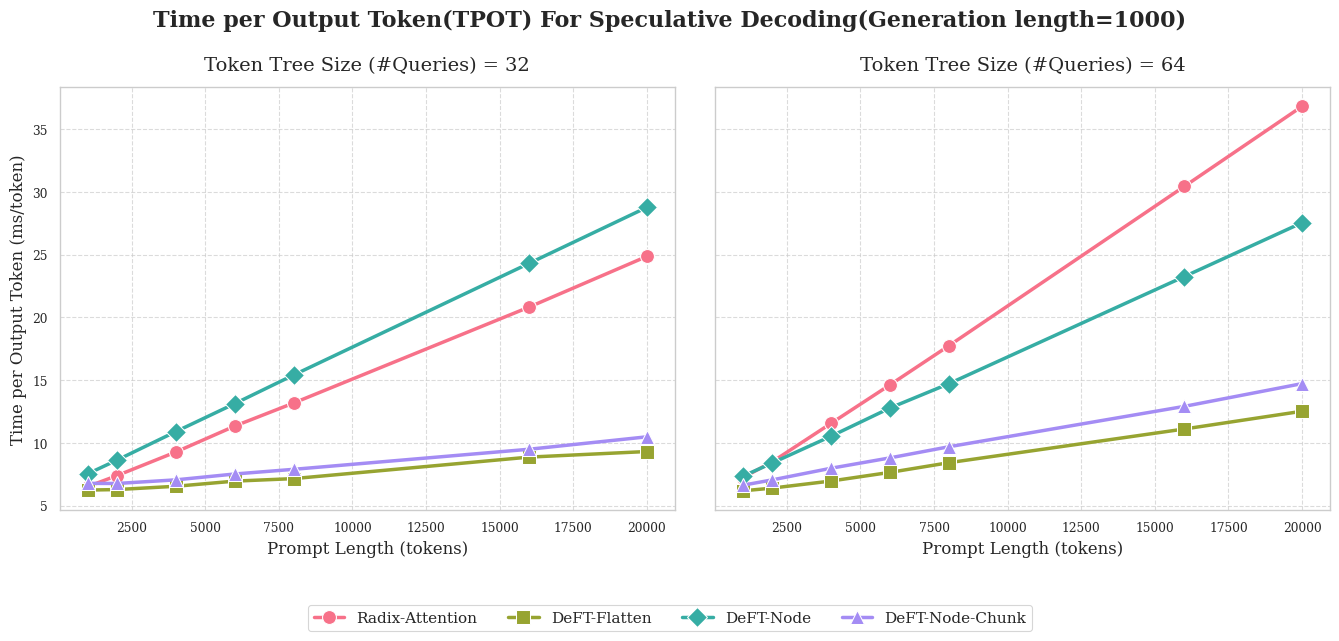

In [56]:
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.axes import Axes
from adjustText import adjust_text
import textwrap

# Style configuration
sns.set_theme(context='paper', style='whitegrid')
plt.rcParams['font.family'] = 'serif'
color_palette = sns.color_palette("husl", n_colors=len(methods))
markers = ['o', 's', 'D', '^']  # Different marker shapes

# Create canvas
fig, axes = plt.subplots(1, len(widths), figsize=(14, 6), sharey=True)


# Define custom legend names
legend_names = {
    "radix": "Radix-Attention",
    "deft_flatten": "DeFT-Flatten",
    "deft_node": "DeFT-Node",
    "deft_node_chunk": "DeFT-Node-Chunk"
}
# Iterate over each width subplot
for ax_idx, width in enumerate(widths):
    cur_ax: Axes = axes[ax_idx]
    
    # Plot lines for each method
    for method_idx, method in enumerate(methods):
        # Extract data
        x = prompt_lens
        y = [results[width][plen][method]["tpot"] for plen in prompt_lens]
        
        # Plot main line
        sns.lineplot(
            x=x, y=y,
            color=color_palette[method_idx],
            marker=markers[method_idx],
            markersize=10,
            linewidth=2.5,
            ax=cur_ax,
            label=legend_names[method]  # Use custom names from the dictionary
        )
        
        # Add data labels (avoid overlap)
        # texts = []
        # for xi, yi in zip(x, y):
        #     texts.append(cur_ax.text(
        #         xi, yi * 1.02, f'{yi:.1f}',
        #         ha='center', va='bottom',
        #         fontsize=9, color=color_palette[method_idx],
        #         bbox=dict(facecolor='white', alpha=0.8, edgecolor='none')
        #     ))
        
        # # Automatically adjust label positions (optional)
        # adjust_text(texts, ax=cur_ax)
        
        # # Add labels only for radix and deft_flatten
        # if method in ["radix", "deft_flatten"]:
        #     for xi, yi in zip(x, y):
        #         label = f'{yi:.1f}'
        #         wrapped_label = '\n'.join(textwrap.wrap(label, width=10))  # Max 10 characters per line
        #         cur_ax.text(
        #             xi, yi * 1.02, wrapped_label,
        #             ha='center', va='bottom',
        #             fontsize=9, color=color_palette[method_idx],
        #             bbox=dict(facecolor='white', alpha=0.8, edgecolor='none')
        #         )

    # Axis beautification
    cur_ax.set_title(f"Token Tree Size (#Queries) = {width}", fontsize=14, pad=12)
    cur_ax.set_xlabel("Prompt Length (tokens)", fontsize=12)
    cur_ax.set_ylabel("Time per Output Token (ms/token)", fontsize=12)
    
    # Grid settings
    cur_ax.grid(True, linestyle='--', alpha=0.7)
    cur_ax.set_axisbelow(True)
    
    # Legend position adjustment
    cur_ax.legend(
        loc='upper left',
        bbox_to_anchor=(0, 1.15),
        frameon=True,
        ncol=2,
        fontsize=11
    )

# Global adjustments
plt.tight_layout(pad=3.0)
plt.subplots_adjust(top=0.85)  # Make space for the global title

# Add global title (optional)
fig.suptitle("Time per Output Token(TPOT) For Speculative Decoding(Generation length=1000)", 
            y=0.98, 
            fontsize=16, 
            fontweight='bold')

# Save output
handles, labels = axes[0].get_legend_handles_labels()  # Get legend info from the first subplot
fig.legend(
    handles, labels,
    loc='upper center',  # Legend position
    bbox_to_anchor=(0.5, 0),  # Fine-tune legend position
    ncol=len(methods),  # Number of columns in the legend
    fontsize=11,
    frameon=True
)

# Remove legends from individual subplots
for ax in axes:
    ax.get_legend().remove()
plt.savefig('tpot_analysis.pdf', bbox_inches='tight')
plt.show()

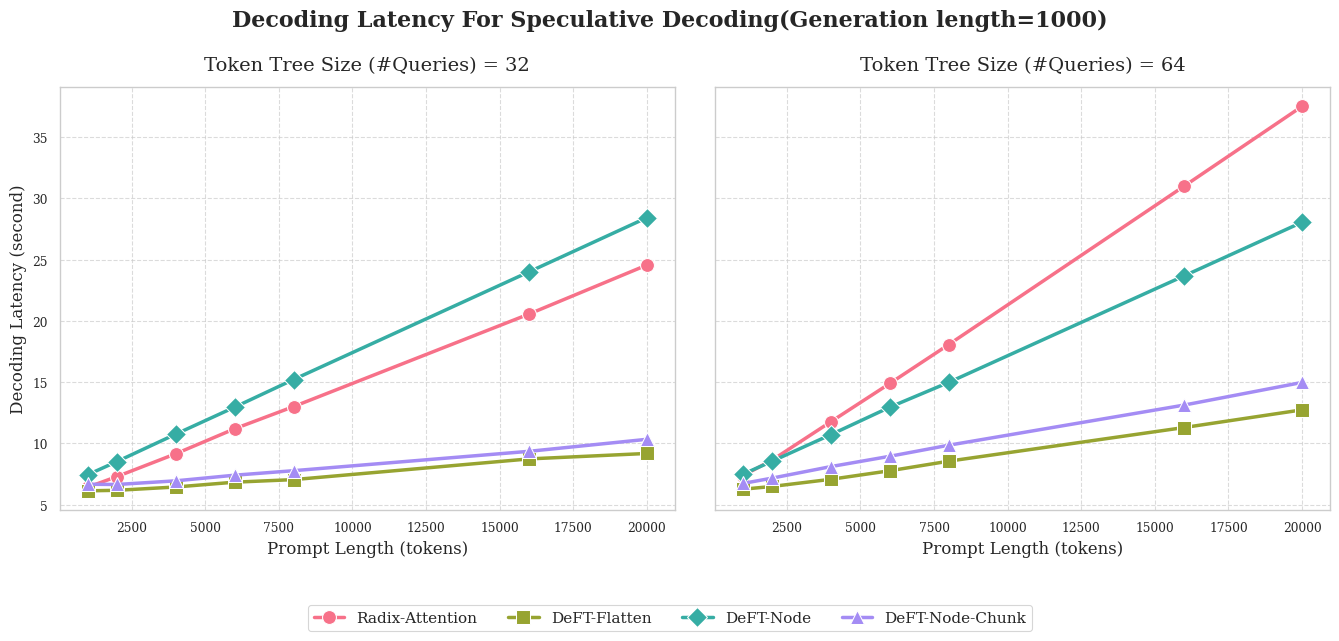

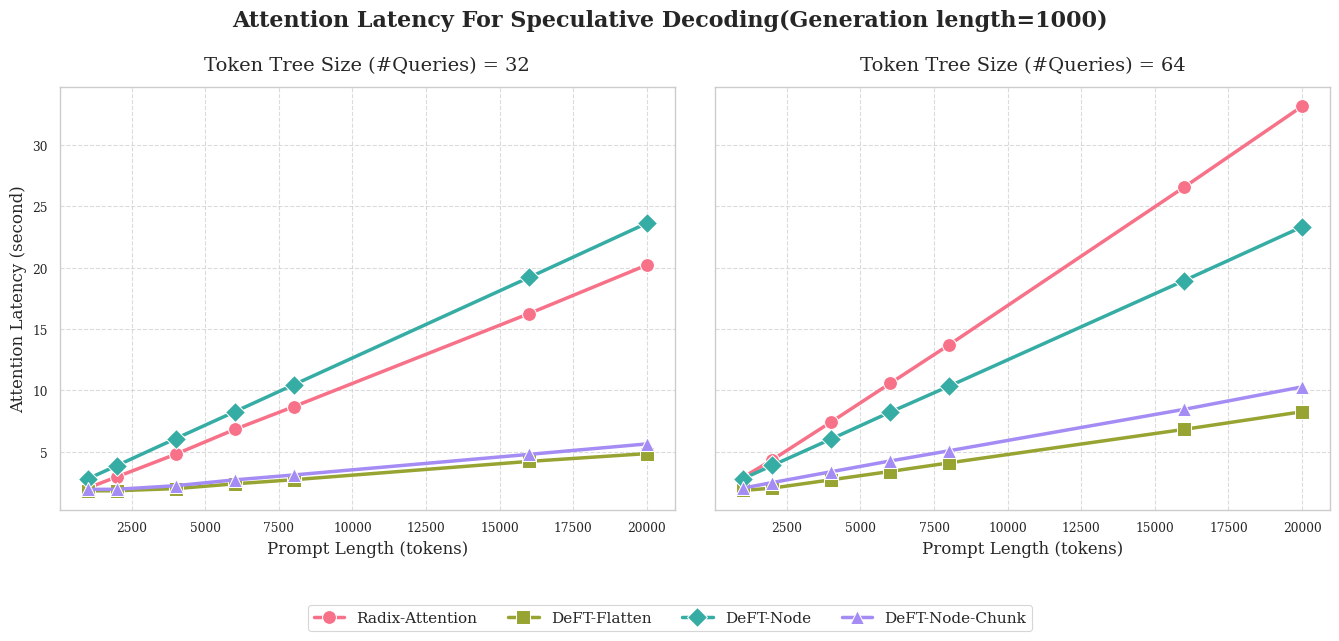

In [57]:
# Function to plot latency (decoding or attention)
def plot_latency(latency_type, ylabel, title_suffix, filename):
    # Create canvas
    fig, axes = plt.subplots(1, len(widths), figsize=(14, 6), sharey=True)

    # Iterate over each width subplot
    for ax_idx, width in enumerate(widths):
        cur_ax: Axes = axes[ax_idx]
        
        # Plot lines for each method
        for method_idx, method in enumerate(methods):
            # Extract data
            x = prompt_lens
            y = [results[width][plen][method][latency_type]/1000 for plen in prompt_lens] # convert to seconds
            
            # Plot main line
            sns.lineplot(
                x=x, y=y,
                color=color_palette[method_idx],
                marker=markers[method_idx],
                markersize=10,
                linewidth=2.5,
                ax=cur_ax,
                label=legend_names[method]  # Use custom names from the dictionary
            )
            
            # # Add data labels (avoid overlap)
            # if method in ["radix", "deft_flatten"]:  # Only label radix and deft_flatten
            #     for xi, yi in zip(x, y):
            #         label = f'{yi:.1f}'
            #         wrapped_label = '\n'.join(textwrap.wrap(label, width=10))  # Max 10 characters per line
            #         cur_ax.text(
            #             xi, yi * 1.02, wrapped_label,
            #             ha='center', va='bottom',
            #             fontsize=9, color=color_palette[method_idx],
            #             bbox=dict(facecolor='white', alpha=0.8, edgecolor='none')
            #         )

        # Axis beautification
        cur_ax.set_title(f"Token Tree Size (#Queries) = {width}", fontsize=14, pad=12)
        cur_ax.set_xlabel("Prompt Length (tokens)", fontsize=12)
        cur_ax.set_ylabel(ylabel, fontsize=12)
        
        # Grid settings
        cur_ax.grid(True, linestyle='--', alpha=0.7)
        cur_ax.set_axisbelow(True)
        
        # Legend position adjustment
        cur_ax.legend(
            loc='upper left',
            bbox_to_anchor=(0, 1.15),
            frameon=True,
            ncol=2,
            fontsize=11
        )

    # Global adjustments
    plt.tight_layout(pad=3.0)
    plt.subplots_adjust(top=0.85)  # Make space for the global title

    # Add global title (optional)
    fig.suptitle(f"{title_suffix} For Speculative Decoding(Generation length=1000)", 
                y=0.98, 
                fontsize=16, 
                fontweight='bold')

    # Save output
    handles, labels = axes[0].get_legend_handles_labels()  # Get legend info from the first subplot
    fig.legend(
        handles, labels,
        loc='upper center',  # Legend position
        bbox_to_anchor=(0.5, 0),  # Fine-tune legend position
        ncol=len(methods),  # Number of columns in the legend
        fontsize=11,
        frameon=True
    )

    # Remove legends from individual subplots
    for ax in axes:
        ax.get_legend().remove()
    plt.savefig(filename, bbox_inches='tight')
    plt.show()

# Plot Decoding Latency
plot_latency(
    latency_type="forward",  # Use "forward" for decoding latency
    ylabel="Decoding Latency (second)",
    title_suffix="Decoding Latency",
    filename="decoding_latency.pdf"
)

# Plot Attention Latency
plot_latency(
    latency_type="attn_comp",  # Use "attn_comp" for attention latency
    ylabel="Attention Latency (second)",
    title_suffix="Attention Latency",
    filename="attention_latency.pdf"
)